In [2]:
import simpy
import numpy as np
import statistics
import matplotlib.pyplot as plt

In [3]:
np.random.seed(12345)

In [ ]:
"""
Used sources: 
- https://stackoverflow.com/questions/73384766/simple-m-m-1-queuing-simulation-with-simpy-departure-placement-issue
- https://simpy.readthedocs.io/en/latest/examples/bank_renege.html
- https://www.youtube.com/watch?v=eSNfC-HOl44
"""

'\nUsed: https://stackoverflow.com/questions/73384766/simple-m-m-1-queuing-simulation-with-simpy-departure-placement-issue\nhttps://simpy.readthedocs.io/en/latest/examples/bank_renege.html\nhttps://www.youtube.com/watch?v=eSNfC-HOl44\n'

In [70]:
def generate_inter_arrival_time(labda):
    return np.random.exponential(labda)

def generate_service_time(mu):
    return np.random.exponential(mu)

observation_times = []
queue_lengths = []
server_lengths = []
def observe(env, servers):
    """
    Takes the environment and servers as arguments in order to refer to the right server

    Uses two lists in order to plot meaningful results. 
    One is used to append the current timestep
    The other is used to state the length of the queue
    """
    while True:
        # current time
        observation_times.append(env.now)
        # current queue length
        queue_lengths.append(len(servers.queue))
        # current server processing length (either 0 or 1)
        server_lengths.append((len(servers.users)))

        # make an observation every 1 timestep
        yield env.timeout(1)

def generator(env, servers, labda, mu):
    """
    In case of a cafe or shop, this simulates the entire environment i.e. the shop.
    """
    # set i in order to be able to identify customers
    i = 0 

    while True:
        i+=1
        service_time = generate_service_time(mu)
        yield env.timeout(generate_inter_arrival_time(labda))
        env.process(customer(env, i, service_time, servers))

waiting_times = []
service_times = []
def customer(env, customer, service_time, servers):
    """
    Processes a customer

    First argument is the environment that it will be operating in
    second argument is the server, so that the customer generator knows what are
    the servers that it have access to
    """
    with servers.request(priority=service_time) as request:
        # Customer arrives
        arrival_time = env.now
        # customer gets serviced
        print(f"At time: {env.now: .2f} | customer {customer} joins queue with service time {service_time:.2f}")
        yield request # request and wait until server is free
        # customer has been serviced 
        print(f"At time: {env.now: .2f} | customer {customer} is being served with service time {service_time:.2f}")
        service_times.append(service_time)
        yield env.timeout(service_time) # service takes time labda
        # departs
        print(f"At time: {env.now: .2f} | customer {customer} departs with service time {service_time:.2f}")
        departure_time = env.now
        waiting_times.append(departure_time - arrival_time)
# intuition for yield: pause function until this event happens

In [72]:
"""
Run a simulation
"""
labda = 4/8 # average number of arrivals per time period
mu = 8/8 # average number of customers served per time period
env = simpy.Environment()
servers = simpy.PriorityResource(env, capacity=1)
env.process(generator(env, servers, labda, mu))
env.process(observe(env, servers))
env.run(until=10000)

At time:  0.47 | customer 1 joins queue with service time 1.32
At time:  0.47 | customer 1 is being served with service time 1.32
At time:  0.89 | customer 2 joins queue with service time 0.18
At time:  1.05 | customer 3 joins queue with service time 0.71
At time:  1.79 | customer 1 departs with service time 1.32
At time:  1.79 | customer 2 is being served with service time 0.18
At time:  1.97 | customer 2 departs with service time 0.18
At time:  1.97 | customer 3 is being served with service time 0.71
At time:  2.50 | customer 4 joins queue with service time 0.17
At time:  2.68 | customer 3 departs with service time 0.71
At time:  2.68 | customer 4 is being served with service time 0.17
At time:  2.85 | customer 4 departs with service time 0.17
At time:  3.13 | customer 5 joins queue with service time 0.03
At time:  3.13 | customer 5 is being served with service time 0.03
At time:  3.16 | customer 5 departs with service time 0.03
At time:  3.86 | customer 6 joins queue with service ti

Average Waiting Time Is : 11.1813
Average Service Time Is :  0.2946
average number of customers in the system:  2713.00


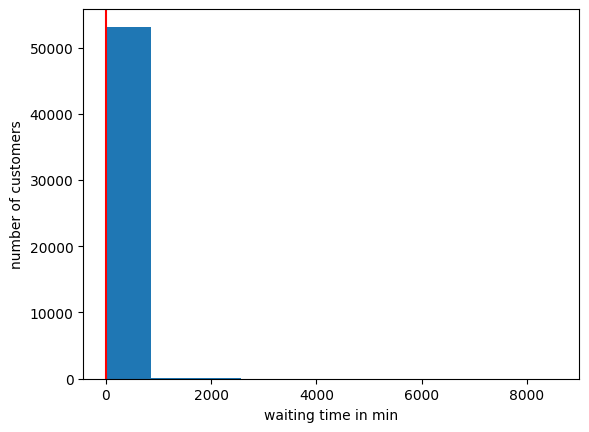

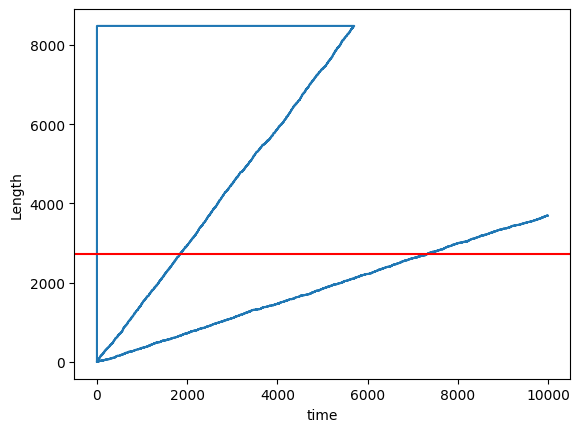

In [73]:
"""
Print and plot results
"""
# some statistics
average_waitingTime = statistics.mean(waiting_times)
average_serviceTime = statistics.mean(service_times)
average_q_length = statistics.mean(queue_lengths)
# average number of customers in the system (waiting and being served)
total_in_system = np.add(queue_lengths, server_lengths)
average_total_in_system = statistics.mean(total_in_system)

print("Average Waiting Time Is : %7.4f" % (average_waitingTime))
print("Average Service Time Is : %7.4f" % (average_serviceTime))
print(f"average number of customers in the system: {average_total_in_system: .2f}")



plt.figure()
plt.hist(waiting_times)
plt.xlabel("waiting time in min")
plt.ylabel("number of customers")
plt.axvline(average_waitingTime, color="red")

plt.figure()
plt.step(observation_times, queue_lengths, where="post")
plt.xlabel("time")
plt.ylabel("Length")
plt.axhline(average_q_length, color="red") 